# AutoEncoder Fashion MNIST

Note: This notebook is designed to run with GPU runtime.

Import modules and set random seeds.

In [1]:
import os, random, copy
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import colormaps
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the Fashion MNIST dataset and store into NumPy arrays.

In [2]:
(train_images, train_labels), _ = fashion_mnist.load_data()
train_images = np.pad(train_images, ((0, 0), (2, 2), (2, 2)))
train_images = train_images.reshape(
                    (len(train_images), 32*32)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Show sample images for 10 categories.

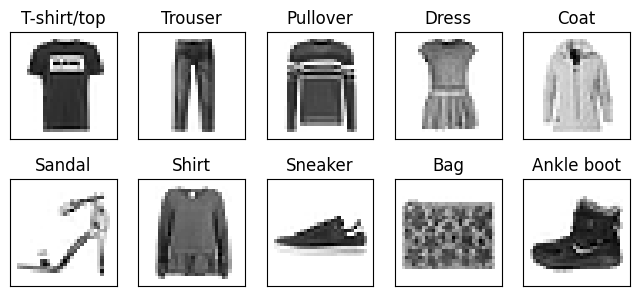

In [3]:
labels = [np.argmax(label) for label in train_labels]
sample_images = np.array([train_images[labels.index(i)] for i in range(10)])
texts = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig = plt.figure(figsize=(8, 3.5))
for i in range(10):
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(texts[i])
    subplot.imshow(sample_images[i].reshape((32, 32)), interpolation='none',
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

Define the encoder with convolutional filters.

In [4]:
encoder = models.Sequential(name='encoder')
encoder.add(layers.Input(shape=(32*32,), name='encoder_input'))
encoder.add(layers.Reshape((32, 32, 1), name='reshape'))
encoder.add(layers.Conv2D(32, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_filter1')) # (16, 16, 32)
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_filter2')) # (8, 8, 64)
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_filter3')) # (4, 4, 128)
encoder.add(layers.Flatten(name='flatten'))
encoder.add(layers.Dense(2, name='embedding_space'))

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter1 (Conv2D)                │ (None, 16, 16, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter2 (Conv2D)                │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter3 (Conv2D)                │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_space (Dense)              │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

Define the decoder with transoposed convolutional filters.

In [5]:
decoder = models.Sequential(name='decoder')
decoder.add(layers.Input(shape=(2,), name='decoder_input'))
decoder.add(layers.Dense(4 * 4 * 128, name='expand'))
decoder.add(layers.Reshape((4, 4, 128), name='reshape'))
decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_transpose1')) # (8, 8, 64)
decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_transpose2')) # (16, 16, 32)
decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same',
                activation='sigmoid', name='conv_transpose3')) # (32, 32, 1)
decoder.add(layers.Flatten(name='flatten'))

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ expand (Dense)                       │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose1 (Conv2DTranspose)    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose2 (Conv2DTranspose)    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose3 (Conv2DTranspose)    │ (None, 32, 32, 1)           │             289 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,689 (385.50 KB)

 Trainable params: 98,689 (385.50 KB)

 Non-trainable params: 0 (0.00 B)

Define AutoEncoder by combining the encoder and the decoder.

In [6]:
model = models.Model(inputs=encoder.inputs[0],
                     outputs=decoder(encoder(encoder.inputs[0])),
                     name='CNN_AutoEncoder')
model.summary()

Model: "CNN_AutoEncoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Sequential)                 │ (None, 2)                   │          96,770 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Sequential)                 │ (None, 1024)                │          98,689 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 195,459 (763.51 KB)

 Trainable params: 195,459 (763.51 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model using the Adam optimizer, and MSE as a loss function.

In [7]:
model.compile(optimizer='adam', loss='mse')

Define a function to show reconstructed images.

In [8]:
def show_result():
    results = model.predict(sample_images, verbose=0)

    fig = plt.figure(figsize=(10, 2))
    for i in range(10):
        subplot = fig.add_subplot(2, 10, i+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(sample_images[i].reshape((32, 32)), interpolation='none',
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

        subplot = fig.add_subplot(2, 10, i+11)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(results[i].reshape((32, 32)), interpolation='none',
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

Train the model and show the result.

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0752
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0296
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0271
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0258
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0250
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0244
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0240
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0236
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0233
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0231
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0229
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0227
Epoch 13/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0225
Epoch 14/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0224
Epoch 15/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - l

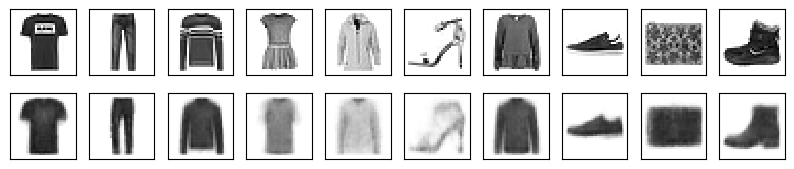

In [9]:
%%time
history = model.fit(train_images, train_images,
                    batch_size=128, epochs=50)
show_result()

Show the embeddings of training data.

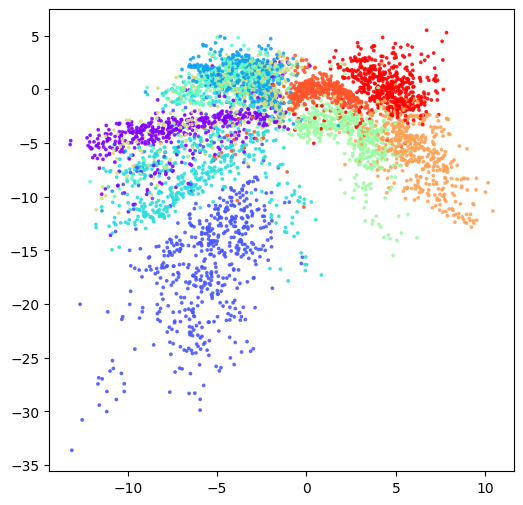

In [10]:
embeddings = encoder.predict(train_images[:5000], verbose=0)
example_labels = np.argmax(train_labels[:5000], axis=1)

fig = plt.figure(figsize=(6, 6))
subplot = fig.add_subplot(1, 1, 1)
_ = subplot.scatter(embeddings[:, 0], embeddings[:, 1],
                    cmap='rainbow', c=example_labels, alpha=0.8, s=3)

Show reconstruction images over the embedding space.

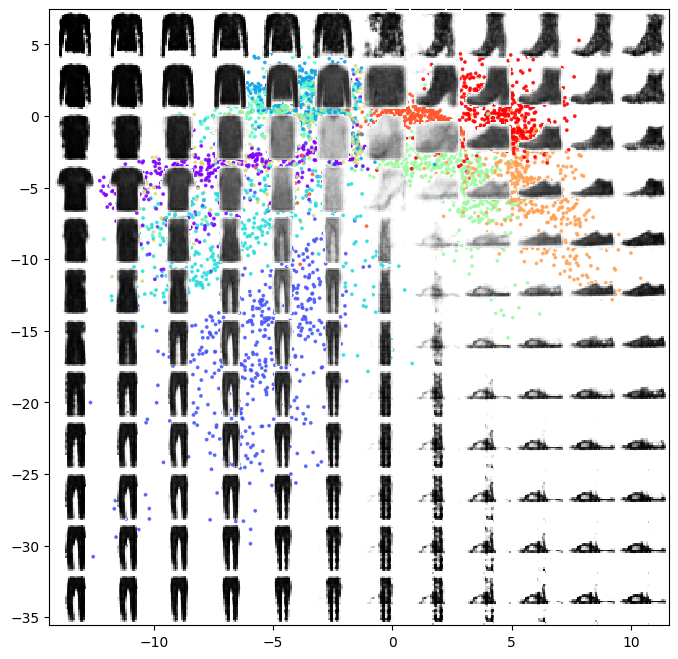

In [11]:
x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), 12)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), 12)
xv, yv = np.meshgrid(x, y)
grid = np.array([*zip(xv.flatten(), yv.flatten())])
reconstructions = decoder.predict(grid, verbose=0)

fig = plt.figure(figsize=(8, 8))
subplot = fig.add_subplot(1, 1, 1)
subplot.scatter(embeddings[:, 0], embeddings[:, 1],
                cmap='rainbow', c=example_labels, alpha=0.8, s=3)

my_cmap = copy.copy(colormaps['gray_r'])
my_cmap.set_bad(alpha=0)
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(12*12):
    subplot = fig.add_subplot(12, 12, i + 1)
    subplot.axis('off')
    # make background transparent
    img = [*map(lambda x: np.nan if x < 0.02 else x, reconstructions[i])]
    subplot.imshow(np.array(img).reshape((32, 32)), interpolation='none',
                   vmin=0, vmax=1, cmap=my_cmap)

Show reconstructed images from a circile on the embedding space.

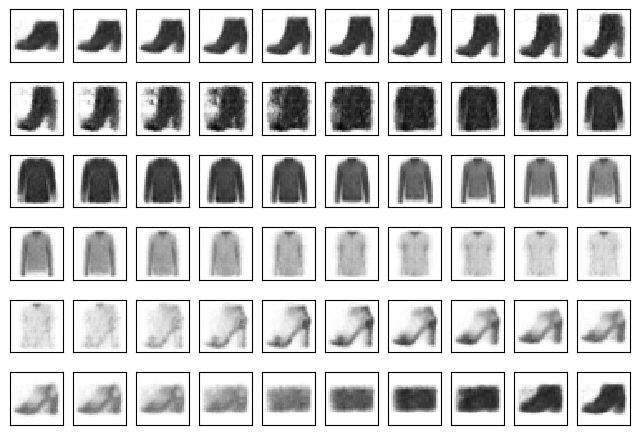

In [12]:
samples = [[3*np.cos(theta), 3*np.sin(theta)]
           for theta in np.linspace(0, 2*np.pi, 60)]
reconstructions = decoder.predict(np.array(samples), verbose=0)

fig = plt.figure(figsize=(8, 5.5))
for i in range(60):
    subplot = fig.add_subplot(6, 10, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(reconstructions[i].reshape((32, 32)), interpolation='none',
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)